# Cluster Imagez - What's the value of the different modes

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


from tqdm import tqdm

import glob, pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 

##hack don't know why i suddenly need to do this :/
plt.rcParams['axes.facecolor'] = 'white'

In [2]:
import mflow
from zdata import PdDataStats, ZPdDataset
import utilz, content, preprocess, extract
import report

from sklearn.preprocessing import StandardScaler, PowerTransformer , OneHotEncoder 

In [3]:
report.ZReporter.start("fundusEDA_Clustering")

In [4]:
pdstats = PdDataStats(
                {PdDataStats.DATA_DICT_RECORDZ_KEY: content.STARE_FUNDUS_CONTENT_FPATH,
                PdDataStats.DATA_DICT_HAS_HEADERZ_KEY: True,
                'rec_parser': utilz.FileIO.row_parser                     
                },
                 ftype=PdDataStats.TYPE_TXT_LINES_FILE ) 

pdstats.dframe.describe() 

,fname,fpath,ishape,imin,imax,imean,istd,Normal,Emboli,BRAO,...,ASR,HTR,Coats,MA,CNV,UNDEF,dcodez_id,dcodez_short,dcodez_desc,dnotes
count,397,397,397,397,397,397,397,397,397,397,...,397,397,397,397,397,397,397,397,397,210
unique,397,397,1,2,17,397,397,2,2,2,...,2,2,2,2,2,2,48,48,48,75
top,im0275,/mnt/externz/zRepoz/datasets/fundus/stare/im02...,"(605, 700, 3)",0,255,86.98691932310115,91.12101625384672,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14,UNDEF,Unknown Diagnosis,Choroidal Neovascularization AND Age Related M...
freq,1,1,397,371,373,1,1,358,384,390,...,364,361,383,389,336,239,90,90,90,33


In [5]:
def fda_load_fmapz(fmapz_dir, show_it=False):
    if fmapz_dir == _FMAPZ_DIR_RGB:
        tz = ['lbp', 'vessel', 'green', 'red', 'blue', 'eigenz', 'color-eq',  'update-rgb']
        chanz = [ *list(range(5)), 8, (5,6,7)]  
    else:
        tz = ['lbp', 'vessel', 'green', 'red', 'blue', 'yellow', 'eigenz', 'color-eq',  'update-rgb']
        chanz = [ *list(range(6)), 9, (6,7,8)]  
    for fmap_file in sorted( glob.glob(f"{fmapz_dir}/*.fmap.pkl") ):
        with open( fmap_file, "rb") as fd:
            fmap = pickle.load( fd )
        if show_it:
            imgz = [ *[ fmap[:,:,i] for i in chanz ], fmap[:,:,2:5]]
            utilz.Image.plot_images_list( imgz, titlez=tz, nc=len(imgz) , cmap='gray')
        yield fmap

In [6]:
### **** TODO: fix sick+okay/undef 88888
_CLASSES = ['sick', 'okay', 'undef', 'sick-n-undef']
_CLASS_LABELZ = {'sick':0, 'okay':1, 'undef':2, 'sick-n-undef':3}
_N_CLASSES = 22
    
def get_data_infor(X_data):    
    if _N_CLASSES <= 2:
        cname = 'Normal'
    else:
        cname = 'condition'
    data_infor = [ f"{x[0]}__{_CLASSES[int(float(x[1]))]}__{x[2]}" for x in zip(X_data['fname'],X_data[cname], X_data['dcodez_short'])]
    print(data_infor[0])
    return data_infor


if _N_CLASSES > 2:
    pdstats.dframe['condition'] = np.where( ( pdstats.dframe['Normal'] == '1.0') & ( pdstats.dframe['UNDEF'] == '0.0') , 1, 
                                np.where( ( pdstats.dframe['Normal'] == '0.0')&( pdstats.dframe['UNDEF'] == '1.0'), 2, 
                                    np.where(( pdstats.dframe['Normal'] == '1.0')&( pdstats.dframe['UNDEF'] == '1.0'), 3, 0)) ) 
    print( pdstats.dframe['condition'].unique() )
    print( pdstats.dframe['condition'].value_counts())
    _Y_DATA = pdstats.dframe['condition'].values.astype(np.float32) ##TODO: 'dcodez_short'
    _N_CLASSES = len( _CLASSES)
else:
    _Y_DATA = pdstats.dframe['Normal'].values.astype(np.float32) ##TODO: 'dcodez_short'
    _N_CLASSES = 2

print(_Y_DATA[107:107+7])


_DATA_INFOR = get_data_infor(pdstats.dframe) 
# _DATA_INFOR 

[0 2 1 3]
0    202
2    156
1     37
3      2
Name: condition, dtype: int64
[2. 2. 0. 0. 0. 0. 0.]
im0001__sick__BDR-NPDR


In [7]:
_FMAPZ_DIR_RGB = "/mnt/fatsie/xRepoz/output/__00_FMAPZ__RGB/F47" ## No Yellow + RGB only
_FMAPZ_DIR_LAB = "/mnt/fatsie/xRepoz/output/__00_FMAPZ__RGB_LAB_combo/F47" ## with Yellow + LAB&RGB

In [8]:
_USE_LAB = True
if _USE_LAB:
    FMAPZ_DATA = [x for x in tqdm( fda_load_fmapz(_FMAPZ_DIR_RGB) )]
else:
    FMAPZ_DATA = [x for x in tqdm( fda_load_fmapz(_FMAPZ_DIR_LAB) )]

397it [00:04, 86.90it/s] 


## Setting up the pipeline

In [9]:
## ======= Channel selectors   =======                  
### ORDER = lbp + vessel + g + r + b + y + origi + eigenz + updated 
if _USE_LAB:
    _L, _V, _G, _R, _B, _Y, _Ori, _E = 0, 1, 2, 3, 4, 5, (6,7,8), 9
else:
    _L, _V, _G, _R, _B, _Ori, _E = 0, 1, 2, 3, 4, (5,6,7), 8

channelz_origi = [('channelz_origi',extract.ChannelzSelector( ls_channelz=_Ori ) )] 
channelz_g_only = [('channelz_green',extract.ChannelzSelector( ls_channelz=(_G,) ) )] 
channelz_grb = [('channelz_grb',extract.ChannelzSelector( ls_channelz=(_G, _R, _B) ) )] 
channelz_vgrb = [('channelz_vgrb',extract.ChannelzSelector( ls_channelz=(_V, _G, _R, _B) ) )] 
channelz_vgrby = [('channelz_vgrby',extract.ChannelzSelector( ls_channelz=(_V, _G, _R, _B, _Y) ) )] 

channelz_lbp_only = [('channelz_lbp_only',extract.ChannelzSelector( ls_channelz=(_L,) ) )] 
channelz_lbp_grn = [('channelz_lbp_green', extract.ChannelzSelector( ls_channelz=(_L, _G) ) )] 
channelz_lbp_origi = [('channelz_lbp_origi',extract.ChannelzSelector( ls_channelz=(_L, *_Ori) ) )] 
channelz_lbp_grb = [('channelz_lbp_grb', extract.ChannelzSelector( ls_channelz=(_L, _G, _R, _B) ) )] 
channelz_lbp_grby = [('channelz_lbp_grby', extract.ChannelzSelector( ls_channelz=(_L, _G, _R, _B, _Y) ) )] 
channelz_lbp_vgrb = [('channelz_lbp_vgrb', extract.ChannelzSelector( ls_channelz=(_L, _V, _G, _R, _B) ) )] 

## TODO: on fundus only bila lbp 
channelz_eigz_only = [('channelz_eigz',extract.ChannelzSelector( ls_channelz=(_E,) ) )] 
channelz_eigz_lbp = [('channelz_eigz_lbp',extract.ChannelzSelector( ls_channelz=(_E, _L) ) )] 
channelz_eigz_rb = [('channelz_eigz_rb',extract.ChannelzSelector( ls_channelz=(_E, _R, _B) ) )]
channelz_eigz_rby = [('channelz_eigz_rby',extract.ChannelzSelector( ls_channelz=(_E, _R, _B, _Y) ) )]
channelz_eigz_lbp_rb = [('channelz_eigz_lbp_rb',extract.ChannelzSelector( ls_channelz=(_E, _L,  _R, _B) ) )]
channelz_eigz_lbp_rby = [('channelz_eigz_lbp_rby',extract.ChannelzSelector( ls_channelz=(_E, _L,  _R, _B, _Y) ) )]



In [10]:
## Reshapez 
flattenor = [ ('flatten', preprocess.Flattenor()), ]
scaler_p = [('scaler', StandardScaler()), ]

# 2. Setup Clustering model

In [11]:
import cv2
import clustering
import pickle 
import torch
import numpy as np 
import os
from glob import glob

from sklearn.pipeline import Pipeline

import seaborn as sns


import utilz

In [22]:
_n_clusters = 4 
_img_resize = (224,224)
_tensor_vgg_img_format = (1,3,224,224)

_data_pipez = [ #channelz_origi, channelz_g_only, 
               channelz_grb, 
               #channelz_vgrb, channelz_vgrby,
              
               #channelz_lbp_only, channelz_lbp_grn, channelz_lbp_origi,
               #channelz_lbp_grb,channelz_lbp_grby, channelz_lbp_vgrb,
              
               #channelz_eigz_only,channelz_eigz_lbp, 
               channelz_eigz_rb, 
               #channelz_eigz_rby, channelz_eigz_lbp_rb, channelz_eigz_lbp_rby
                ]

get_pipe_name = lambda x: x[0][0] 
fmap_chan_to_tensor_img = lambda x: torch.tensor( utilz.Image.resize_image_dim(x[0], _img_resize).reshape(1, x[1], *_img_resize ).astype('f') )
encoded_to_vectorized_for_kmeans = lambda x: np.dstack(x).reshape(-1, 3)
cluster_centers_to_img = lambda x: x.reshape(*_img_resize,3)

_idn, _fname, _condition, _conditionID, _diseases = list(range(5))
fmap_name_parse = lambda x: (x.split('.'))[0].split('_')

def fmap_fname_to_data(fdir, fp="*.pkl"):
    O_ = []
    for i, fp in enumerate( sorted(glob(f"{fdir}/*.pkl")) ):
        o = [i] + list(fmap_name_parse(os.path.basename(fp) ) ) #[i, *fmap_name_parse(os.path.basename(fp) ) ]
        o[_conditionID] = _CLASS_LABELZ.get(o[_condition], '') 
        O_.append( o )
    return O_ 

_outdir = "/mnt/fatsie/xRepoz/output/_00_Kmeans"
def save_pipe_kmeans_to_file(pname, centerz, labelz):
    with open( f"{_outdir}/{pname}.pkl", 'wb') as fd:
        o = {'centers': centerz, 'labels': labelz, 'n_clusters':_n_clusters}
        pickle.dump( o, fd )
        
def train_encoder_and_fit(X_data, c=3): ## TODO: VGG @ c = 3 error 
    cnn = clustering.AutoEncoderVGG(pretrained=True, n_channelz=c)
    clustering.train_autoencoder(cnn, X_data )
    return [list(clustering.predict_autoencoder(cnn, x)) for x in X_data ] 

def cv2_kmeans_cluster(X_data, n_clusters=2):
    stopping_criteria =  (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labelz, (centerz ) = cv2.kmeans(X_data, n_clusters, None, 
                                        stopping_criteria, 10, cv2.KMEANS_RANDOM_CENTERS ) 
    return np.uint8( centerz ), labelz.flatten() 


def run_clustering_on_fmap_data(channz, fmapz, n_clusters=_n_clusters):
    print( "***** RUNNING: ", get_pipe_name(channz) ) 
    # 1. select channels from fmap 
    X_data = Pipeline( channz ).fit_transform( fmapz ) 
    i_dim = len(X_data[0].shape )
    print("1. In fmap data: ", X_data[0].shape )
    c = X_data[0].shape[2] if i_dim >2 else 1
    # 2. reshape and to tensor
    X_data = [fmap_chan_to_tensor_img( (x, c)) for x in X_data] 
    print("2. Reshaped tensor: ", X_data[0].shape)
    # 3. encode features 
    X_encoded = train_encoder_and_fit(X_data )
    print("3. Encoded data: ", X_encoded[0][0].shape )
#     print("3b. encoded ndstack: ", encoded_to_vectorized_for_kmeans(X_encoded[0][0]).shape )
    # 4. reshape for k-means OR not
#     X_encoded = np.vectorize( encoded_to_vectorized_for_kmeans )( X_encoded )
    X_encoded = np.array([ encoded_to_vectorized_for_kmeans(x) for x in X_encoded ])
    print("4. Vectorized data: ", X_encoded[0].shape )
    # 5. kemans run 
    centerz, labelz = cv2_kmeans_cluster(X_encoded, n_clusters)
    print("5. Kmeans clusters: ", len(centerz) , ", ", len(labelz)) 
    # 6. save to file 
    save_pipe_kmeans_to_file(get_pipe_name(channz), centerz, labelz) 
    print("DONE")
    
    return centerz, labelz
    
    
_SUB_FMAPZ = lambda x: FMAPZ_DATA[ : min(x,len(FMAPZ_DATA)) ]

In [13]:
__FMAPZ_n = _SUB_FMAPZ(10)

In [23]:
if _USE_LAB:
    _VIZ_DATA = fmap_fname_to_data(_FMAPZ_DIR_RGB)  
else:
    _VIZ_DATA = fmap_fname_to_data(_FMAPZ_DIR_LAB) 
    
_VIZ_DATA = _VIZ_DATA[:len(__FMAPZ_n)]
    
def plot_centers(name, centerz, n=_n_clusters):
#     print( type(centerz[0]), centerz[0].shape )
    imgz = [cluster_centers_to_img(x) for x in centerz]
    tz = [f"cluster_{c}" for c in range( n )]
    print(f"Data Channel {name}")
    utilz.Image.plot_images_list(imgz, titlez=tz, nc=len(imgz), save=name, tfont=7)
    
def plot_clusters(name, labelz, n=_n_clusters):
    conditionz = [ int(v[_conditionID]) for v in _VIZ_DATA ]
    conditionz = [ v[_condition] for v in _VIZ_DATA ]
    idz = [ int(v[int(_idn)]) for v in _VIZ_DATA ]
    labelz = [ f"cluster-{l+1}" for l in  labelz ] #int(l)
    df = pd.DataFrame(list(zip(idz, conditionz, labelz)), columns=['idz', 'condz', 'labelz'])
#     g = sns.FacetGrid( df, col='labelz', height=4, aspect=1, hue='condz')
#     g.map( sns.swarmplot, 'condz', 'idz')
#     g = sns.swarmplot( df, 'labelz','condz', height=4, aspect=1)
    g = sns.factorplot(x="labelz", y="condz", hue="labelz", col="condz", data=df, kind="swarm")
    g.set_title( name )
    g.add_legend();
        
    
        

In [ ]:
## For each pipeline
##   1. fetch channel + encode + k-means 
##   3. save centers and labels 
cluster_results = {} 
for channel in tqdm(_data_pipez ):
    fname = get_pipe_name(channelz_eigz_rb) 
    centerz, labelz = run_clustering_on_fmap_data(channel, __FMAPZ_n)
    cluster_results[fname] = (centerz, labelz)


  0%|          | 0/2 [00:00<?, ?it/s]

***** RUNNING:  channelz_grb
1. In fmap data:  (168, 168, 3)
2. Reshaped tensor:  torch.Size([1, 3, 224, 224])



  0%|          | 0/3 [00:00<?, ?it/s]

Setup AE



 33%|███▎      | 1/3 [00:09<00:18,  9.19s/it]

E 0: loss 26.740135669708252



 67%|██████▋   | 2/3 [00:18<00:09,  9.23s/it]

E 1: loss 18.8715261220932



100%|██████████| 3/3 [00:27<00:00,  9.23s/it]

E 2: loss 13.212928295135498



 50%|█████     | 1/2 [00:31<00:31, 31.84s/it]

3. Encoded data:  torch.Size([1, 3, 224, 224])
4. Vectorized data:  (50176, 3)
5. Kmeans clusters:  4 ,  10
DONE
***** RUNNING:  channelz_eigz_rb
1. In fmap data:  (168, 168, 3)
2. Reshaped tensor:  torch.Size([1, 3, 224, 224])



  0%|          | 0/3 [00:00<?, ?it/s]

Setup AE



 33%|███▎      | 1/3 [00:09<00:18,  9.48s/it]

E 0: loss 26.553149938583374



 67%|██████▋   | 2/3 [00:19<00:09,  9.71s/it]

E 1: loss 19.110228180885315


In [20]:
print("**** PLOTING Facet " )
# conditionz = [ int(v[_conditionID]) for v in _VIZ_DATA ]
conditionz = [ v[_condition] for v in _VIZ_DATA ]
idz = [ int(v[int(_idn)]) for v in _VIZ_DATA ]

_IDZ, _CONDZ, _LBLZ, _CHANZ = [], [], [], []
for fname, cls in cluster_results.items():
    centerz, labelz = cls 
    channz = [f"{fname}"]*len(_VIZ_DATA)     
    labelz = [ f"cluster-{l+1}" for l in  labelz ] #int(l)
    _IDZ.append(idz)
    _CONDZ.append( conditionz )
    _LBLZ.append( labelz )
    _CHANZ.append( channz ) 
    
df = pd.DataFrame(list(zip(_IDZ, _CONDZ, _LBLZ, _CHANZ)), columns=['idz', 'condz', 'labelz', 'channz'])
df.head()

g = sns.factorplot(x="labelz", y="condz", hue="labelz", col="channz", data=df, kind="swarm")
g.set_title( 'K-Means Clusters' )
g.add_legend();
 
    

**** PLOTING Facet 


,idz,condz,labelz,channz


In [ ]:
print("**** PLOTING CENTERS " )
for fname, cls in cluster_results.items():
    centerz, labelz = cls 
    plot_centers(fname, centerz)

# 3. Permute and Run

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm 
from sklearn.pipeline import Pipeline


import model

In [12]:
dpipez = [
    Pipeline(channelz_origi), # origi only
    
    Pipeline(channelz_g_only), # green only 
    Pipeline(channelz_grb), # green red blue 
    Pipeline(channelz_vgrb),  # vessel, green red blue  
    Pipeline(channelz_vgrby),  # vessel, green red blue  yellow   
    
    Pipeline(channelz_lbp_only), #lbp only 
    Pipeline(channelz_lbp_origi), #lbp and origi 
    Pipeline(channelz_lbp_grn), #lbp green 
    Pipeline(channelz_lbp_grb), #lbp green red blue
    Pipeline(channelz_lbp_grby), #lbp green red blue yellow
    Pipeline(channelz_lbp_vgrb), ## lbp vessel green red blue    
    
    Pipeline(channelz_eigz_only), #eigz_
    Pipeline(channelz_eigz_lbp), #eigz_ lbp 
    Pipeline(channelz_eigz_rb), #eigz_ lbp rb 
    Pipeline(channelz_eigz_rby), #eigz_ lbp rb yellow
    Pipeline(channelz_eigz_lbp_rb), #eigz_ lbp_rb 
#     Pipeline(channelz_eigz_lbp_rby), #eigz_ lbp_rb yellow
]
mpipez = [ ( Pipeline(flattenor+[('svm', svm.SVC() ) ]), {'kernel':('linear', 'rbf'), 'C':[1, 10]}) ,  ## 
            ( Pipeline(flattenor+[('logit', LogisticRegression() ) ]), {'C':[1,10]} ), ##
         ]  


In [39]:
def run_sub_sample(nm='fundusEDA', n=None, dpipez=dpipez, mpipez=mpipez, outdir='./output'):
    log_fname = f"xLAB_acc_v3_{nm}_{'ALL' if n is None else n}" 
    report.ZReporter.start(log_fname, log_screen=False) 
    
#     if n is None:        
#         small_df = pdstats.dframe
#     else:
#         small_df = pdstats.dframe.sample(n, random_state=1)  
        
#     X_data = small_df  
#     y_data = small_df['Normal'].values.astype(np.float32) ##TODO: 'dcodez_short'
#     print("Loaded into PdFrame data of size: ", len(small_df) , " and into y_data of size ", len(y_data) )  
#     __X_data = Pipeline(defaultz_setup_X_data).fit_transform( X_data )

    __X_data = FMAPZ_DATA
    print("Loaded and setup X_data", len(__X_data) )
    
    mgr = model.ZTrainingManager() 
    mgr.build_permutationz(data_pipez=dpipez, model_pipez=mpipez)
    search_output = mgr.run( __X_data , _Y_DATA, train_test_split=1.)
    c="*="
    print(f"{c*10} End ZTrainingManager for sub_n_{n} {c*10}\n {search_output[0]}")
    
    ## get metrics for plotting 
    grp = [f"{s[0]}__{s[1]}" for s in search_output]
#     hue_grp = [f"{s[1].split(" ")[0]}" for s in search_output]
    acc = [s[2] for s in search_output]
    acc = np.nan_to_num (np.array( acc) )
    max_acc = acc.max()
    min_acc = np.min( acc[np.nonzero(acc)] )
    mean_acc = acc.mean()
    median_acc = np.median(acc)
    print(f"Max: {max_acc} \tMin: {min_acc} \tMean: {mean_acc} \tMedia: {median_acc}")
    
    with open(f"{outdir}/{log_fname}.csv", 'w') as fd:
        for g, a in zip(grp, acc):
            fd.write( "\t".join( [str(g), str(a)] ))
            fd.write( "\n")
    
    ## 3. plot for all metrics
    plt.figure(figsize=(15,20))
    plt.barh( grp, acc);
    plt.axvline(x=max_acc, color='r', linestyle='--')
    plt.axvline(x=min_acc, color='gray', linestyle='--')
    plt.title("Permutation Accuracies")
    plt.tight_layout()
    plt.savefig( f"{outdir}/{log_fname}__ALL_METRICS.png", facecolor='w', dpi=100)
    plt.show();
    #plt.clf()
    ## 4. get diffs/uncommon
    grp_diff = []
    acc_diff = []
    base_set = None 
    g_lbl="{}_{}".format
    for sout in search_output:
        g1, g2, ac = sout[0], sout[1], sout[2]        
        if (base_set is None) and (ac == max_acc):
            base_set = (g_lbl(g1, g2), ac )
        if ac < max_acc:
            grp_diff.append( g_lbl(g1, g2) )
            acc_diff.append( ac )
    grp_diff = [base_set[0],] + grp_diff
    acc_diff = [base_set[1],] + acc_diff

    plt.figure(figsize=(15,7))
    plt.barh( grp_diff, acc_diff);
    plt.axvline(x=max_acc, color='r', linestyle='--')
    plt.axvline(x=min_acc, color='gray', linestyle='--')
    plt.grid(b=True, which='minor', axis='x', color='#000000', linestyle='--')
    plt.title("Different from Max")
    plt.tight_layout()
    plt.savefig( f"{outdir}/{log_fname}__DIFF__METRICS.png", facecolor='w', dpi=100)
    plt.show();

  0%|          | 0/32 [00:00<?, ?it/s]

Loaded and setup X_data 397


100%|██████████| 32/32 [17:32<00:00, 32.90s/it]


*=*=*=*=*=*=*=*=*=*= End ZTrainingManager for sub_n_None *=*=*=*=*=*=*=*=*=*=
 ['Perm_1', 'svm channelz_origi', 0.901768945738795, Pipeline(steps=[('data_pipe',
                 Pipeline(steps=[('channelz_origi',
                                  ChannelzSelector(ls_channelz=(6, 7, 8)))])),
                ('model_pipe',
                 Pipeline(steps=[('flatten', Flattenor()),
                                 ('svm', SVC(C=1))]))]), {'model_pipe__svm__C': 1, 'model_pipe__svm__kernel': 'rbf'}]
Max: 0.901768945738795 	Min: 0.8715166742804934 	Mean: 0.8972827362824222 	Media: 0.901768945738795


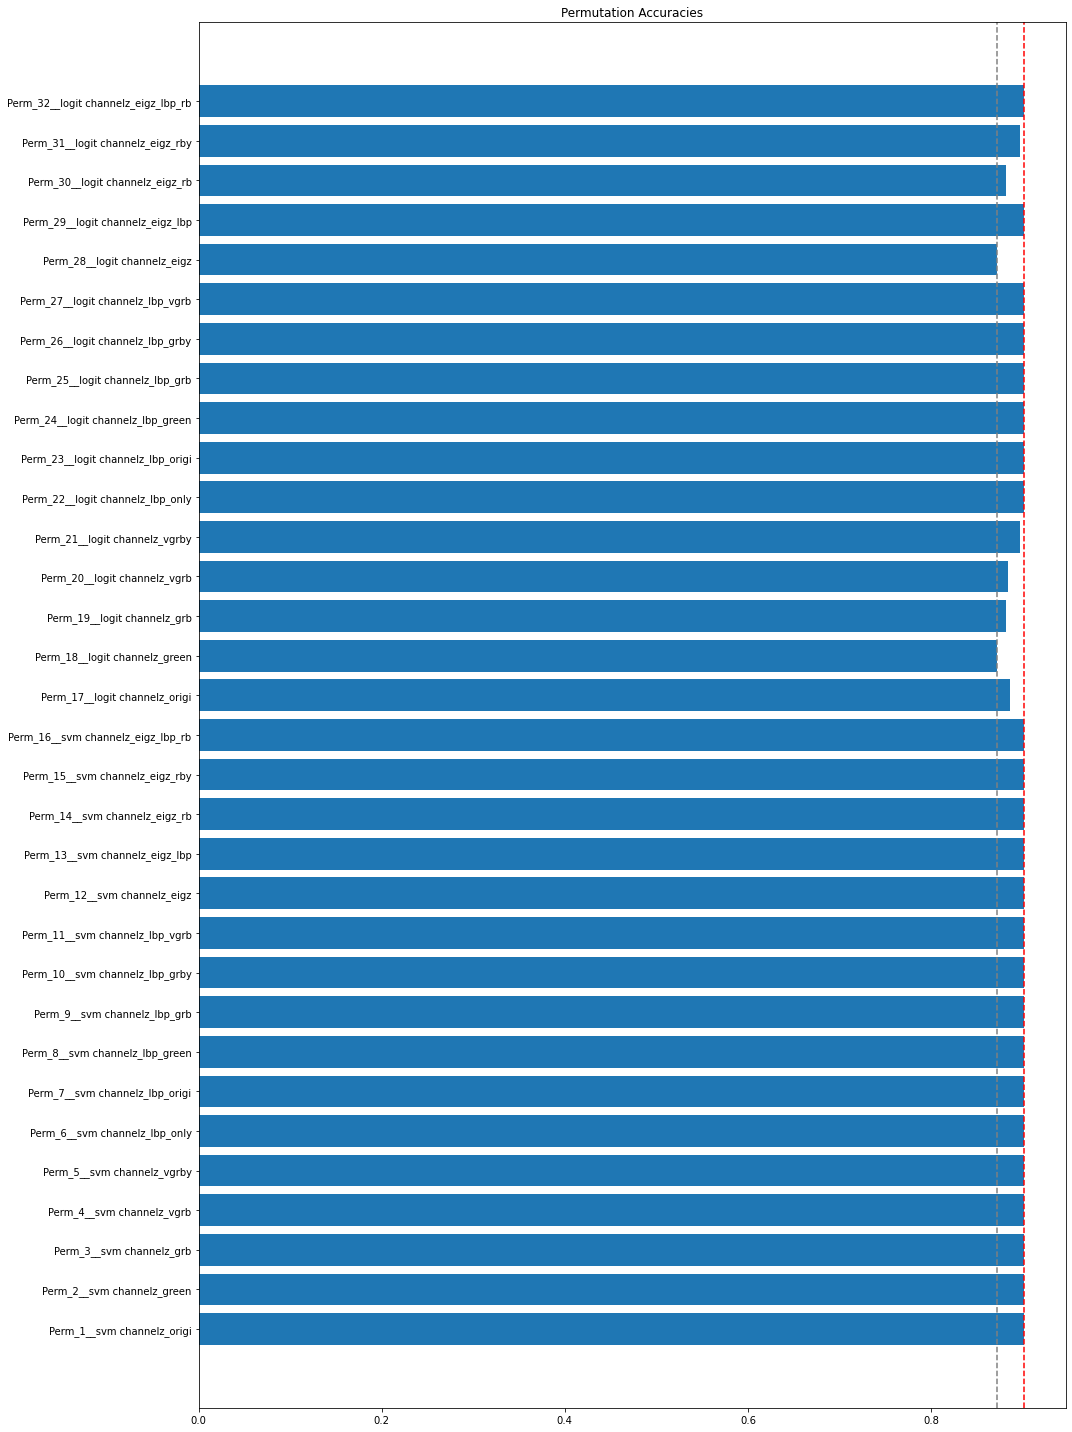

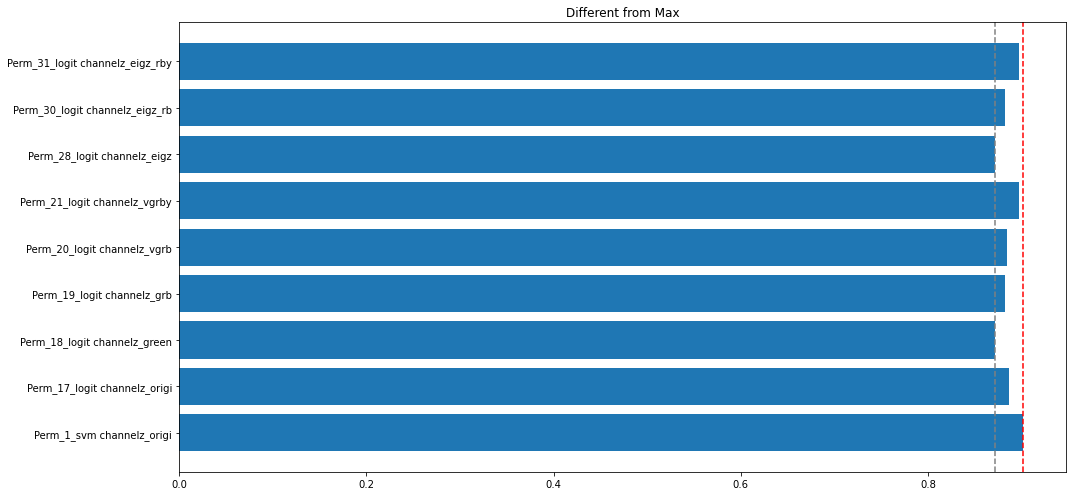

In [40]:
run_sub_sample(nm=f'{_N_CLASSES}-ary')

In [60]:
import seaborn as sns
sns.set_theme(style='ticks', palette='pastel')
sns.color_palette("mako", as_cmap=True)

In [61]:
search_outputs = pd.read_csv("./output/20210319_all_lba_rgb_svm_logit.tsv", sep="\t")
search_outputs.describe(include='all')

,Mode,Permutation,Classifier,Features,Accuracy
count,58,58,58,58,58.000000
unique,2,32,2,16,NaN
top,With_LBA,Perm_19,logit,channelz_origi,NaN
freq,32,2,29,4,NaN
mean,NaN,NaN,NaN,NaN,0.896689
std,NaN,NaN,NaN,NaN,0.010787
min,NaN,NaN,NaN,NaN,0.848853
25%,NaN,NaN,NaN,NaN,0.901769
50%,NaN,NaN,NaN,NaN,0.901769
75%,NaN,NaN,NaN,NaN,0.901769


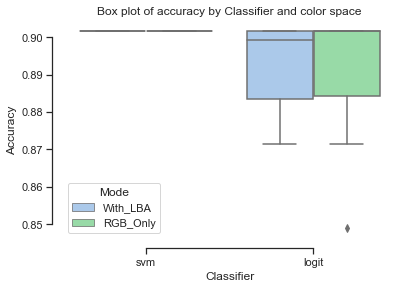

In [63]:
sns.boxplot(x='Classifier', y='Accuracy', hue='Mode', data=search_outputs,
           palette=['b','g'])
sns.despine(offset=10, trim=True)
plt.title("Box plot of accuracy by Classifier and color space");

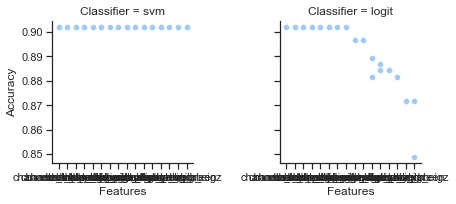

In [76]:
g = sns.FacetGrid( search_outputs, col='Classifier')
g.map( sns.scatterplot, 'Features', 'Accuracy',)
# g.map( sns.regplot, 'Mode', 'Accuracy', color='0.3', fit_reg=False, x_jitter=.1)
g.add_legend(); 

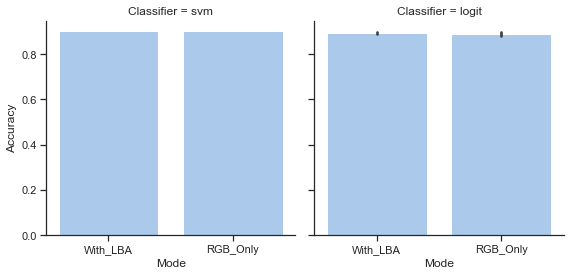

In [82]:
g = sns.FacetGrid( search_outputs, col='Classifier', height=4, aspect=1)
g.map( sns.barplot, 'Mode', 'Accuracy')
g.add_legend(); 

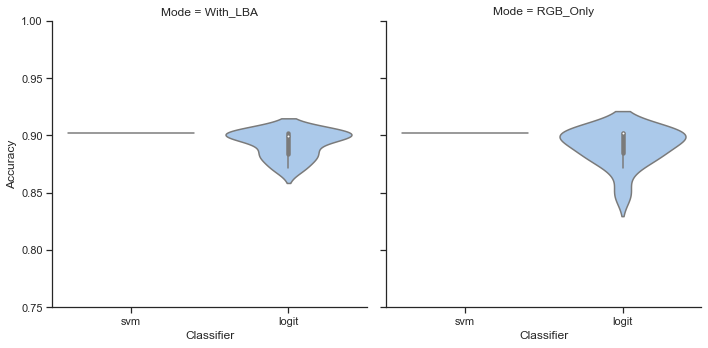

In [103]:
g = sns.FacetGrid(search_outputs, col="Mode", col_wrap=2, height=5, ylim=(0.75, 1))
# g.map(sns.boxplot, "Classifier", "Accuracy");
g.map(sns.violinplot, "Classifier", "Accuracy");
# plt.title("Average accuracy by classifier and color space (n=59)")

plt.show();